# Feed Forward Neural Networks for J1-J2 Model

#### Importing the packages

In [12]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import netket as nk
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax.linen as nn
import netket.nn as nknn

In [13]:
L = 6    # linear size, so total sites = L*L
J1 = 1.0
J2 = 0.5

lattice = nk.graph.Square(length=L, max_neighbor_order=2, pbc=True)
print("Number of sites:", lattice.n_nodes)


Number of sites: 36


In [14]:
from collections import Counter

# Sequence of color indices, same order as lattice.edges()
edge_colors = lattice.edge_colors

print("Unique edge colors:", set(edge_colors))
print("Edges per type:", Counter(edge_colors))

Unique edge colors: {0, 1}
Edges per type: Counter({0: 72, 1: 72})


In [15]:
edges = lattice.edges()  # returns (i, j) only
for (idx, (i, j)) in enumerate(edges[:10]):  # first 10 edges
    print(f"edge {idx}: ({i}, {j}), color = {edge_colors[idx]}")

edge 0: (24, 30), color = 0
edge 1: (0, 30), color = 0
edge 2: (6, 12), color = 0
edge 3: (15, 21), color = 0
edge 4: (1, 31), color = 0
edge 5: (3, 4), color = 0
edge 6: (18, 23), color = 0
edge 7: (26, 27), color = 0
edge 8: (16, 17), color = 0
edge 9: (12, 13), color = 0


In [19]:
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=lattice.n_nodes)

H = nk.operator.Heisenberg(
    hilbert=hi,
    graph=lattice,
    J=[J1, J2],
    sign_rule=[False, False],   # one entry per J
)

print("Number of terms in H:", H.n_operators)

Number of terms in H: 144


In [20]:
class FFNN(nn.Module):
    """Simple FFNN NQS: σ -> log ψ(σ), complex-valued."""
    @nn.compact
    def __call__(self, x):
        # x has shape (..., N_sites)
        # Dense layer: features = 2*N, complex weights
        x = nn.Dense(
            features=2 * x.shape[-1],
            use_bias=True,
            param_dtype=jnp.complex128,
            kernel_init=nn.initializers.normal(stddev=0.01),
            bias_init=nn.initializers.normal(stddev=0.01),
        )(x)

        # Non-linearity: element-wise log cosh
        x = nknn.log_cosh(x)

        # Sum over sites → scalar logψ for each configuration
        # shape (...,)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [24]:
# Exchange sampler (preserves total_sz=0)
sampler = nk.sampler.MetropolisExchange(
    hilbert=hi,
    graph=lattice,
    d_max=2,
)


In [25]:
vstate = nk.vqs.MCState(
    sampler=sampler,
    model=model,
    n_samples=1024,
    n_discard_per_chain=10,
)


/var/folders/33/28753zc950g7jnqk3b6ljhdr0000gn/T/ipykernel_65714/2757089679.py:16: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)


In [27]:
# Optimizer
opt = nk.optimizer.Adam(learning_rate=0.01)

# VMC with SR (stochastic reconfiguration)
gs = nk.driver.VMC_SR(
    hamiltonian=H,
    optimizer=opt,
    diag_shift=0.01,         # required
    variational_state=vstate # required
)

print("Number of parameters:", vstate.n_parameters)

Automatic SR implementation choice:  NTK
Number of parameters: 2664


/var/folders/33/28753zc950g7jnqk3b6ljhdr0000gn/T/ipykernel_65714/2757089679.py:16: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)


In [31]:
log = nk.logging.RuntimeLog()

In [32]:
N_opt = 300  # or your n_iter

gs.run(n_iter=N_opt, out=log)


100%|██████████| 300/300 [09:58<00:00,  2.00s/it, Energy=-49.757-0.025j ± 0.076 [σ²=5.2e+00, R̂=1.009]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [37]:
import numpy as np

data   = log.data              # HistoryDict
E_hist = data["Energy"]        # History with keys ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr']

print(E_hist)                  # optional: to inspect
# History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=...)

# Arrays:
iters      = E_hist.iters                  # shape (n_iter,)
energy     = E_hist.Mean.real              # shape (n_iter,)
energy_err = E_hist.Sigma.real             # shape (n_iter,) – this is the standard error of the mean

# Last point:
last_E      = energy[-1]
last_E_err  = energy_err[-1]

print(f"Final energy ≈ {last_E:.6f} ± {last_E_err:.6f}")



History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=300)
Final energy ≈ -49.756579 ± 0.075594


In [38]:
E_per_site     = last_E / lattice.n_nodes
E_per_site_err = last_E_err / lattice.n_nodes

print(f"Final energy per site ≈ {E_per_site:.6f} ± {E_per_site_err:.6f}")


Final energy per site ≈ -1.382127 ± 0.002100


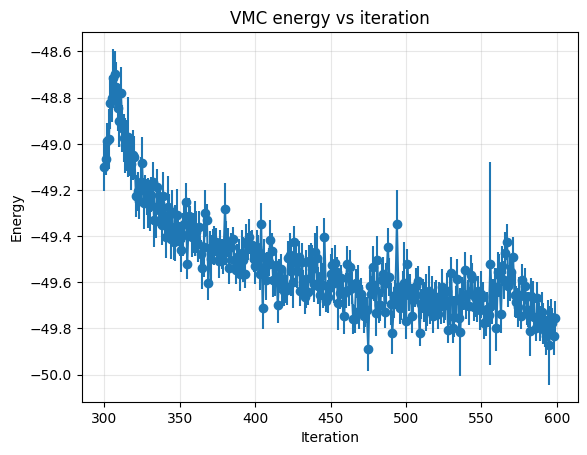

In [39]:
import matplotlib.pyplot as plt

iters      = E_hist.iters
energy     = E_hist.Mean.real
energy_err = E_hist.Sigma.real

plt.errorbar(
    iters,
    energy,
    yerr=energy_err,
    fmt="o-",
)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VMC energy vs iteration")
plt.grid(True, alpha=0.3)
plt.show()
